In [12]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import PIL
from IPython.display import Image
from IPython.display import display as idisplay
import os
import random
import sys

sys.path.append('../albumentations')
import albumentations as A


def max_resize(img, resize = 480):
    img_h, img_w = img.shape[:2]
    r = min(resize / img_h, resize / img_w)
    new_h, new_w = int(r * img_h), int(r * img_w)
    img = cv2.resize(img, (new_w, new_h), cv2.INTER_LINEAR)
    return img
    
    
def display(img, color = 'rgb', resize = None):
    if color == 'bgr':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize is not None:
        max_resize(img, resize)
    img = (255 * img).astype(np.uint8)
    idisplay(PIL.Image.fromarray(img))
    
    
def viz(imgs, transforms):
    if not isinstance(transforms, A.Compose):
        transform = A.Compose(transforms, p = 1.0)
    else:
        transform = transforms
    for img in imgs:
        img2 = transform(image=img)['image']
        display(img)
        display(img2)
        print('\n----------------\n')

In [2]:
import math
import random
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

import cv2
import numpy as np

from albumentations.core.bbox_utils import union_of_bboxes

from albumentations.core.transforms_interface import (
    BoxInternalType,
    DualTransform,
    KeypointInternalType,
    to_tuple,
)
from albumentations.augmentations.geometric import functional as FGeometric
from albumentations.augmentations.crops import functional as F



class _CustomBaseRandomSizedCropNoResize(DualTransform):
    # Base class for RandomSizedCrop and RandomResizedCrop

    def __init__(self, always_apply=False, p=1.0):
        super(_CustomBaseRandomSizedCropNoResize, self).__init__(always_apply, p)

    def apply(self, img, crop_height=0, crop_width=0, h_start=0, w_start=0, interpolation=cv2.INTER_LINEAR, **params):
        return F.random_crop(img, crop_height, crop_width, h_start, w_start)

    def apply_to_bbox(self, bbox, crop_height=0, crop_width=0, h_start=0, w_start=0, rows=0, cols=0, **params):
        return F.bbox_random_crop(bbox, crop_height, crop_width, h_start, w_start, rows, cols)

    def apply_to_keypoint(self, keypoint, crop_height=0, crop_width=0, h_start=0, w_start=0, rows=0, cols=0, **params):
        keypoint = F.keypoint_random_crop(keypoint, crop_height, crop_width, h_start, w_start, rows, cols)
        scale_x = self.width / crop_width
        scale_y = self.height / crop_height
        keypoint = FGeometric.keypoint_scale(keypoint, scale_x, scale_y)
        return keypoint




class CustomRandomSizedCropNoResize(_CustomBaseRandomSizedCropNoResize):
    """Torchvision's variant of crop a random part of the input and rescale it to some size.

    Args:
        height (int): height after crop and resize.
        width (int): width after crop and resize.
        scale ((float, float)): range of size of the origin size cropped
        ratio ((float, float)): range of aspect ratio of the origin aspect ratio cropped
        interpolation (OpenCV flag): flag that is used to specify the interpolation algorithm. Should be one of:
            cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4.
            Default: cv2.INTER_LINEAR.
        p (float): probability of applying the transform. Default: 1.

    Targets:
        image, mask, bboxes, keypoints

    Image types:
        uint8, float32
    """

    def __init__(
        self,
        scale=(0.08, 1.0),
        ratio=(0.75, 1.3333333333333333),
        always_apply=False,
        p=1.0,
    ):

        super(CustomRandomSizedCropNoResize, self).__init__(always_apply=always_apply, p=p
        )
        self.scale = scale
        self.ratio = ratio

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        area = img.shape[0] * img.shape[1]

        for _attempt in range(10):
            target_area = random.uniform(*self.scale) * area
            log_ratio = (math.log(self.ratio[0]), math.log(self.ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))

            w = int(round(math.sqrt(target_area * aspect_ratio)))  # skipcq: PTC-W0028
            h = int(round(math.sqrt(target_area / aspect_ratio)))  # skipcq: PTC-W0028

            if 0 < w <= img.shape[1] and 0 < h <= img.shape[0]:
                i = random.randint(0, img.shape[0] - h)
                j = random.randint(0, img.shape[1] - w)
                return {
                    "crop_height": h,
                    "crop_width": w,
                    "h_start": i * 1.0 / (img.shape[0] - h + 1e-10),
                    "w_start": j * 1.0 / (img.shape[1] - w + 1e-10),
                }

        # Fallback to central crop
        in_ratio = img.shape[1] / img.shape[0]
        if in_ratio < min(self.ratio):
            w = img.shape[1]
            h = int(round(w / min(self.ratio)))
        elif in_ratio > max(self.ratio):
            h = img.shape[0]
            w = int(round(h * max(self.ratio)))
        else:  # whole image
            w = img.shape[1]
            h = img.shape[0]
        i = (img.shape[0] - h) // 2
        j = (img.shape[1] - w) // 2
        return {
            "crop_height": h,
            "crop_width": w,
            "h_start": i * 1.0 / (img.shape[0] - h + 1e-10),
            "w_start": j * 1.0 / (img.shape[1] - w + 1e-10),
        }

    def get_params(self):
        return {}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return "scale", "ratio"


In [ ]:
# augmentation = A.Compose([
#             A.augmentations.geometric.transforms.HorizontalFlip(p=0.5),
#             # A.augmentations.transforms.GaussianBlur(),
#             # A.augmentations.geometric.resize.Resize(),
#             A.augmentations.transforms.ColorJitter(brightness=[0.9, 1.1], contrast=[0.95, 1.05], saturation = 0.05, hue = 0.01, always_apply= False, p = 0.5), 
#             A.augmentations.transforms.RandomToneCurve(scale = 0.1, always_apply= False, p= 0.5),
#             A.augmentations.transforms.Downscale(scale_min = 0.75, scale_max = 0.9, interpolation=cv2.INTER_CUBIC, always_apply= False, p = 0.5),
#             A.augmentations.transforms.ISONoise(color_shift= [0.01, 0.03], intensity= [0.1, 0.5], always_apply= False, p = 0.1),
#             A.augmentations.transforms.GaussNoise(var_limit = [10, 50], mean = 0, per_channel= True, always_apply= False, p = 0.1),
#             A.augmentations.transforms.ImageCompression(quality_lower=70, quality_upper=100, always_apply=False, p=0.4),
#         ], p = 0.5)

48777@840114608.png


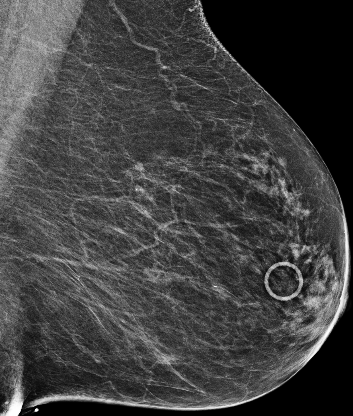


---------------------

9955@1731793299.png


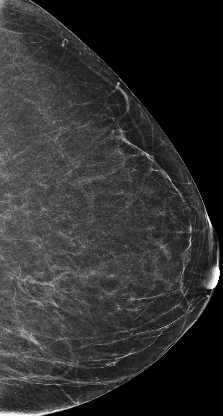


---------------------

17886@513350167.png


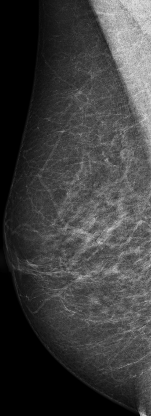


---------------------

50741@769931657.png


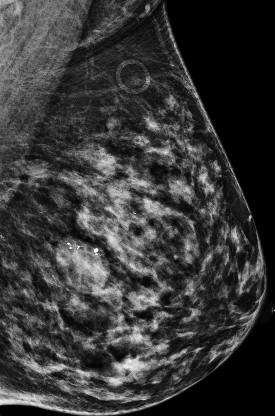


---------------------

52901@843842940.png


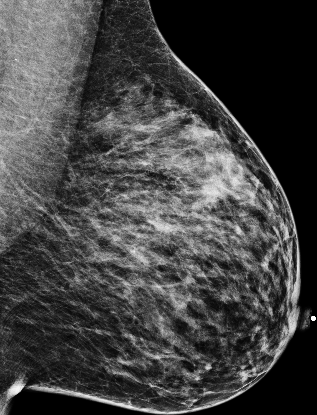


---------------------

58572@1895499651.png


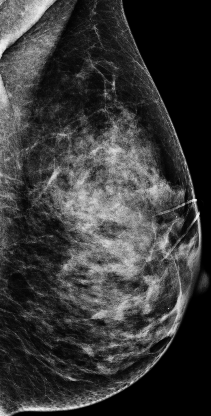


---------------------

14848@876158767.png


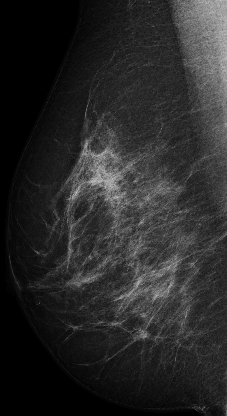


---------------------

19510@398134939.png


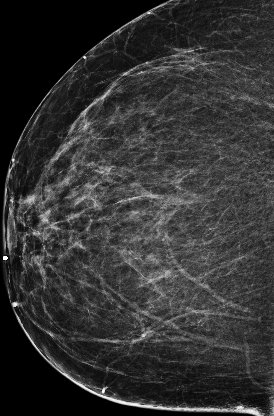


---------------------

33465@632449209.png


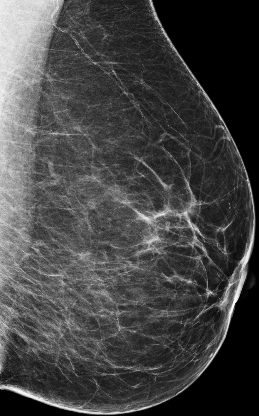


---------------------

64776@42143445.png


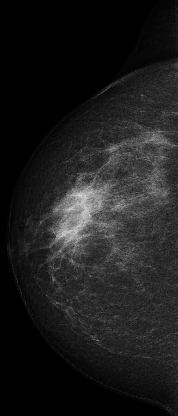


---------------------

44622@40781591.png


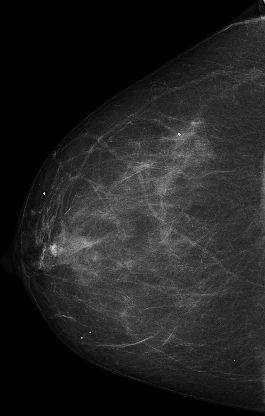


---------------------

27046@581940083.png


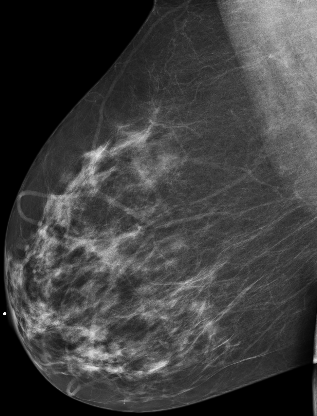


---------------------

30403@463805542.png


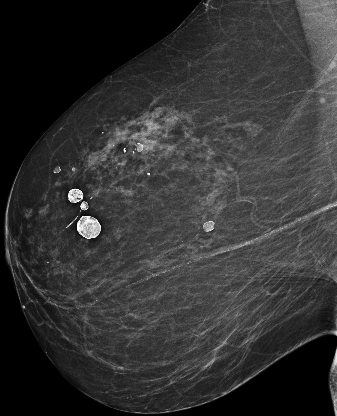


---------------------

16361@600399615.png


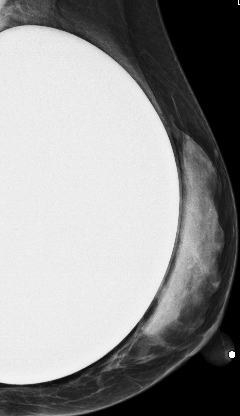


---------------------

5983@1183425241.png


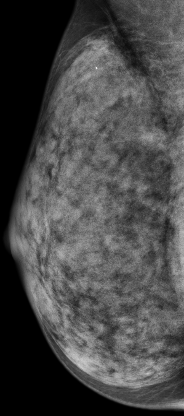


---------------------

23251@1477486748.png


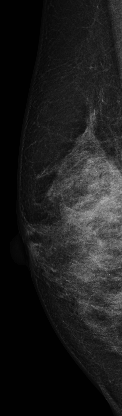


---------------------

61720@1812050532.png


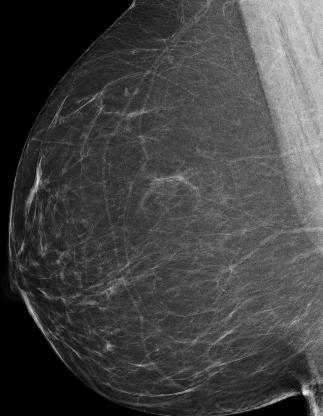


---------------------

3765@386432521.png


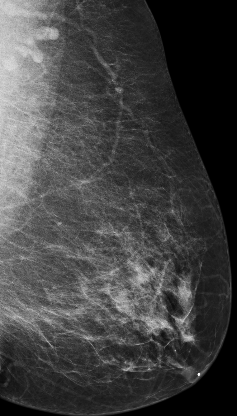


---------------------

44914@1800010426.png


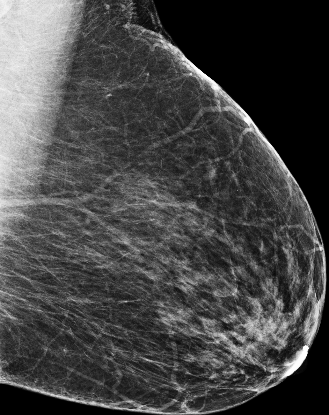


---------------------

18911@252767825.png


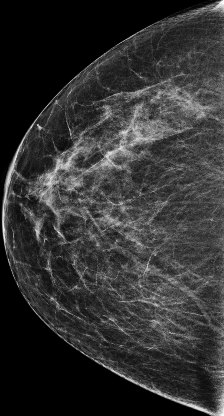


---------------------



In [13]:
random.seed(42)
IMG_DIR = '/home/dangnh36/datasets/.comp/rsna/crops/uint8_voilut_png@yolox_nano_bre_416_datav2/'
img_names = os.listdir(IMG_DIR)
img_names = random.choices(img_names, k = 20)

imgs = []
for img_name in img_names:
    print(img_name)
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = max_resize(img, 416)
    img = img / 255
    display(img)
    imgs.append(img)
    print('\n---------------------\n')

In [ ]:
raise Exception()
# In some systems, in the multiple GPU regime,
# PyTorch may deadlock the DataLoader if OpenCV was compiled with OpenCL optimizations.
# Adding the following two lines before the library import may help.
# For more details pytorch/pytorch#1355

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

#  USING
A.HorizontalFlip(p=1.0)

# dùng cẩn thận
A.AdvancedBlur(blur_limit=(3, 7),
              sigmaX_limit=(0.2, 1.0),
              sigmaY_limit=(0.2, 1.0),
              rotate_limit=90,
              beta_limit=(0.5, 8.0),
              noise_limit=(0.9, 1.1),
              always_apply=True,
              p=1.0)

A.ColorJitter(brightness=[0.6, 1.2],
                  contrast=[0.8, 1.3],
                  saturation=[0.7, 1.3],
                  hue=[-0.05, 0.05],
                  always_apply=True, p=1.0)

# to spoofing only
A.Defocus(radius=(3, 3),
              alias_blur=(0.1, 0.1),
              always_apply=True, p=1.0)


A.Downscale(scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_CUBIC, always_apply=True, p=1.0)

# fake to fake, real to real, not fake to real
# hyperparam not tunned
A.FDA(imgs, beta_limit=0.2, always_apply=True, p=1.0)


# caution
A.GaussNoise(var_limit=(10.0, 20.0), mean=0, per_channel=True, always_apply=True, p=1.0)


A.ISONoise(color_shift=(0.00, 0.00), intensity=(0.1, 0.4), always_apply=True, p=1.0)


# one of
A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.JPEG,
                   always_apply=True, p=1.0)

A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.WEBP,
                   always_apply=True, p=1.0)

# one noise addition at a time
A.MedianBlur(blur_limit=(3,3), always_apply=True, p=1.0)


A.MotionBlur(blur_limit=(3,5), allow_shifted=True, always_apply=True, p=1.0)

# very slow, pregenerated first
A.FDA(fake_paths, beta_limit=[0.9, 1.0], always_apply=True, p=1.0)

A.RGBShift(r_shift_limit=[-20, 20], g_shift_limit=[-20, 20], b_shift_limit=[-20, 20], always_apply=True, p=1.0)


# relative dark/bright between region, like HDR
A.RandomToneCurve(scale=0.2, always_apply=True, p=1.0)

A.RandomGamma(gamma_limit=(120, 120), eps=None, always_apply=True, p=1.0)

A.ToGray(p=0.1)


# unnecessary
A.Affine(scale=None, translate_percent=0.5, translate_px=None,
        rotate=[60, 60], shear=None, interpolation=1, mask_interpolation=0,
         cval=0, cval_mask=0, mode=0, fit_output=False, keep_ratio=True,
         always_apply=True, p=1.0)
A.ShiftScaleRotate (shift_limit=[-0.2, -0.2], scale_limit=[0, 0], rotate_limit=[0, 0],
                        interpolation=1, border_mode=0, value=0, mask_value=None,
                        shift_limit_x=None, shift_limit_y=None, rotate_method='largest_box',
                        always_apply=True, p=1.0)

# random erase
A.CoarseDropout(max_holes=3, max_height=0.2, max_width=0.2, min_holes=3,
   min_height=0.1, min_width=0.1, fill_value=0,
   mask_fill_value=None, always_apply=True, p=1.0)

# cut out screen bezel
A.Lambda(image=None, mask=None, keypoint=None, bbox=None, name=None, always_apply=False, p=1.0)
A.RandomCropFromBorders(crop_left=0.2, crop_right=0.2, crop_top=0.2, crop_bottom=0.2,
                            always_apply=False, p=1.0)


A.Rotate(limit=[-15, 15], interpolation=1, border_mode=0, value=0, mask_value=None,
              rotate_method='largest_box', crop_border=False,
              always_apply=False, p=1.0)


A.CustomRandomSizedCropNoResize(scale=(0.5, 0.6), ratio=(0.8, 0.8),
                                    always_apply=True, p=1.0)


In [ ]:
raise Exception()

# Train full frames:
SIZE = 384

transform = A.Compose([
    # crop
    A.OneOf([
        A.CustomRandomSizedCropNoResize(scale=(0.5, 1.0), ratio=(1.0, 1.0),
                                    always_apply=False, p=0.2),
        A.CustomRandomSizedCropNoResize(scale=(0.5, 1.0), ratio=(0.555, 0.8),
                                    always_apply=False, p=0.6),
        A.RandomCropFromBorders(crop_left=0.15, crop_right=0.15, crop_top=0.15, crop_bottom=0.2,
                                    always_apply=False, p=0.2)
    ], p = 0.9),
    
    A.HorizontalFlip(p=0.5),
    
    # blur
    A.OneOf([
        A.AdvancedBlur(blur_limit=(3, 5),
              sigmaX_limit=(0.2, 1.0),
              sigmaY_limit=(0.2, 1.0),
              rotate_limit=90,
              beta_limit=(0.5, 8.0),
              noise_limit=(0.9, 1.1),
              always_apply=False,
              p=0.6),
        A.MedianBlur(blur_limit=(3,3), always_apply= False, p=0.1),
        A.MotionBlur(blur_limit=(3,5), allow_shifted=True, always_apply=False, p=0.3)
    ], p = 0.1),
    
    # noise
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 20.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        A.ISONoise(color_shift=(0.00, 0.00), intensity=(0.1, 0.4), always_apply=False, p=0.5),
    ], p = 0.15),
    
    A.OneOf([
        A.Downscale(scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_CUBIC,
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_CUBIC, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_LINEAR),
                    always_apply=False, p=0.25),
    ], p = 0.3),
    
    # compression
    A.OneOf([
        A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.JPEG,
                   always_apply=False, p=0.5),
        A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.WEBP,
                   always_apply=False, p=0.5)
    ], p = 0.3),
    
    # color
    A.OneOf([
        A.ColorJitter(brightness=[0.6, 1.2],
                  contrast=[0.8, 1.3],
                  saturation=[0.7, 1.3],
                  hue=[-0.05, 0.05],
                  always_apply=False, p=0.4),
        A.RGBShift(r_shift_limit=[-20, 20], g_shift_limit=[-20, 20], b_shift_limit=[-20, 20],
                   always_apply=False, p=0.2),
        # relative dark/bright between region, like HDR
        A.RandomToneCurve(scale=0.2, always_apply=False, p=0.2),

        A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.2),
    ], p = 0.7),
    
    # resize before pad
    A.OneOf([
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_CUBIC, always_apply=False, p=0.6),
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.2),
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_AREA, always_apply=False, p=0.2),
    ], p = 1.0),
    
    # pad before affine
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE,
                pad_height_divisor=None, pad_width_divisor=None,
                position=A.augmentations.geometric.transforms.PadIfNeeded.PositionType.CENTER,
                border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                always_apply=True, p=1.0),
    
    # affine
    A.OneOf([
        A.Rotate(limit=[-15, 15], interpolation=1, border_mode=0, value=0, mask_value=None,
              rotate_method='largest_box', crop_border=False,
              always_apply=False, p=0.3),
        A.ShiftScaleRotate(shift_limit=[-0.1, 0.1], scale_limit=[-0.1, 0.1], rotate_limit=[-15, 15],
                        interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT,
                        value=0, mask_value=None,
                        shift_limit_x=None, shift_limit_y=None, rotate_method='largest_box',
                        always_apply=False, p=0.7),
    ], p = 0.5),
    
    # random erase
    A.CoarseDropout(max_holes=3, max_height=0.3, max_width=0.3, min_holes=1,
                    min_height=0.15, min_width=0.15, fill_value=0, mask_fill_value=None,
                    always_apply = False, p=0.2),
    
], p = 1.0)



In [ ]:
raise Exception()
# TRAIN FACE CROP 0.5

# Train full frames:
SIZE = 384

transform = A.Compose([
    # crop
    A.OneOf([
        A.CustomRandomSizedCropNoResize(scale=(0.4, 1.0), ratio=(1.0, 1.0),
                                    always_apply=False, p=0.2),
        A.CustomRandomSizedCropNoResize(scale=(0.4, 1.0), ratio=(0.65, 1.0),
                                    always_apply=False, p=0.6),
        A.RandomCropFromBorders(crop_left=0.5, crop_right=0.5, crop_top=0.5, crop_bottom=0.5,
                                    always_apply=False, p=0.2)
    ], p = 0.9),
    
    A.HorizontalFlip(p=0.5),
    
    # blur
    A.OneOf([
        A.AdvancedBlur(blur_limit=(3, 5),
              sigmaX_limit=(0.2, 1.0),
              sigmaY_limit=(0.2, 1.0),
              rotate_limit=90,
              beta_limit=(0.5, 8.0),
              noise_limit=(0.9, 1.1),
              always_apply=False,
              p=0.6),
        A.MedianBlur(blur_limit=(3,3), always_apply= False, p=0.1),
        A.MotionBlur(blur_limit=(3,5), allow_shifted=True, always_apply=False, p=0.3)
    ], p = 0.1),
    
    # noise
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 20.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        A.ISONoise(color_shift=(0.00, 0.00), intensity=(0.1, 0.4), always_apply=False, p=0.5),
    ], p = 0.15),
    
    A.OneOf([
        A.Downscale(scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_CUBIC,
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_CUBIC, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.5, scale_max=0.9,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_LINEAR),
                    always_apply=False, p=0.25),
    ], p = 0.3),
    
    # compression
    A.OneOf([
        A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.JPEG,
                   always_apply=False, p=0.5),
        A.ImageCompression(quality_lower=60, quality_upper= 90,
                   compression_type=A.transforms.ImageCompression.ImageCompressionType.WEBP,
                   always_apply=False, p=0.5)
    ], p = 0.3),
    
    # color
    A.OneOf([
        A.ColorJitter(brightness=[0.6, 1.2],
                  contrast=[0.8, 1.3],
                  saturation=[0.7, 1.3],
                  hue=[-0.05, 0.05],
                  always_apply=False, p=0.4),
        A.RGBShift(r_shift_limit=[-20, 20], g_shift_limit=[-20, 20], b_shift_limit=[-20, 20],
                   always_apply=False, p=0.2),
        # relative dark/bright between region, like HDR
        A.RandomToneCurve(scale=0.2, always_apply=False, p=0.2),

        A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.2),
    ], p = 0.7),
    
    # resize before pad
    A.OneOf([
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_CUBIC, always_apply=False, p=0.6),
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.2),
        A.LongestMaxSize(SIZE, interpolation=cv2.INTER_AREA, always_apply=False, p=0.2),
    ], p = 1.0),
    
    # pad before affine
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE,
                pad_height_divisor=None, pad_width_divisor=None,
                position=A.augmentations.geometric.transforms.PadIfNeeded.PositionType.CENTER,
                border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                always_apply=True, p=1.0),
    
    # affine
    A.OneOf([
        A.Rotate(limit=[-15, 15], interpolation=1, border_mode=0, value=0, mask_value=None,
              rotate_method='largest_box', crop_border=False,
              always_apply=False, p=0.3),
        A.ShiftScaleRotate(shift_limit=[-0.1, 0.1], scale_limit=[-0.1, 0.1], rotate_limit=[-20, 20],
                        interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT,
                        value=0, mask_value=None,
                        shift_limit_x=None, shift_limit_y=None, rotate_method='largest_box',
                        always_apply=False, p=0.7),
    ], p = 0.5),
    
    # random erase
    A.CoarseDropout(max_holes=3, max_height=0.3, max_width=0.3, min_holes=1,
                    min_height=0.15, min_width=0.15, fill_value=0, mask_fill_value=None,
                    always_apply = False, p=0.3),
], p = 1.0)


In [ ]:
breast_transforms = A.Compose([
    # crop
    CustomRandomSizedCropNoResize(scale=(0.5, 1.0), ratio=(0.5, 0.8),
                                always_apply=False, p=0.5),
    
    # flip
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    
    # downscale
    A.OneOf([
        A.Downscale(scale_min=0.75, scale_max=0.95,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.75, scale_max=0.95,
                    interpolation=dict(upscale = cv2.INTER_LANCZOS4, downscale = cv2.INTER_AREA),
                    always_apply=False, p=0.25),
        A.Downscale(scale_min=0.75, scale_max=0.95,
                    interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_LINEAR),
                    always_apply=False, p=0.5),
    ], p = 0.125),
    

    # contrast
    # relative dark/bright between region, like HDR
    A.OneOf([
        A.RandomToneCurve(scale=0.3, always_apply=False, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2), contrast_limit=(-0.4, 0.5),
                               brightness_by_max=True,
                               always_apply=False, p = 0.5)
        
    ], p = 0.5),
    
    # affine
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=None, scale_limit=[-0.15, 0.15], rotate_limit=[-30, 30],
                    interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT,
                    value=0, mask_value=None,
                    shift_limit_x=[-0.1, 0.1], shift_limit_y=[-0.2, 0.2],
                    rotate_method='largest_box',
                    always_apply=False, p=0.6),

        # one of with other affine
        A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, interpolation=cv2.INTER_LINEAR,
                          border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                          approximate=False, same_dxdy=False,
                            always_apply=False, p=0.2),
        
        # distort
        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_LINEAR,
               border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, normalized=True,
               always_apply=False, p=0.2),
        
    ], p = 0.5),
    
    # random erase
    A.CoarseDropout(max_holes=6, max_height=0.15, max_width=0.25, min_holes=2,
                min_height=0.05, min_width=0.1, fill_value=0, mask_fill_value=None,
                always_apply = True, p=1.0),
], p = 1.0)

In [ ]:
############################################################
############################################################
### BREAST CANCER AUGMENT

A.HorizontalFlip(p=1.0)

A.VerticalFlip(p=1.0)

# Crop
CustomRandomSizedCropNoResize(scale=(0.5, 1.0), ratio=(0.5, 0.8),
                                always_apply=True, p=1.0)

# relative dark/bright between region, like HDR
A.RandomToneCurve(scale=0.3, always_apply=True, p=1.0)
A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2), contrast_limit=(-0.4, 0.5),
                           brightness_by_max=True,
                           always_apply=True, p=1.0)



A.OneOf([
    A.Downscale(scale_min=0.75, scale_max=1.0,
                interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_AREA),
                always_apply=False, p=0.25),
    A.Downscale(scale_min=0.75, scale_max=1.0,
                interpolation=dict(upscale = cv2.INTER_LANCZOS4, downscale = cv2.INTER_AREA),
                always_apply=False, p=0.25),
    A.Downscale(scale_min=0.75, scale_max=1.0,
                interpolation=dict(upscale = cv2.INTER_LINEAR, downscale = cv2.INTER_LINEAR),
                always_apply=False, p=0.5),
], p = 0.3),


# Affine
A.ShiftScaleRotate(shift_limit=None, scale_limit=[-0.15, 0.15], rotate_limit=[-30, 30],
                    interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT,
                    value=0, mask_value=None,
                    shift_limit_x=[-0.1, 0.1], shift_limit_y=[-0.2, 0.2],
                    rotate_method='largest_box',
                    always_apply=True, p=1.0)

# one of with other affine
A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, interpolation=cv2.INTER_LINEAR,
                  border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                  approximate=False, same_dxdy=False,
                    always_apply=True, p=1.0)

A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_LINEAR,
               border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, normalized=True,
               always_apply=False, p=1.0)


# Random Erase
A.CoarseDropout(max_holes=6, max_height=0.15, max_width=0.25, min_holes=2,
                min_height=0.05, min_width=0.1, fill_value=0, mask_fill_value=None,
                always_apply = True, p=1.0)







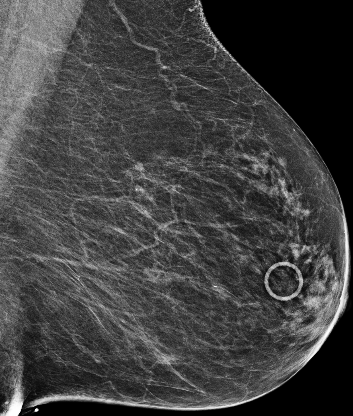

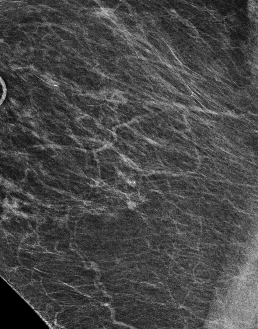


----------------



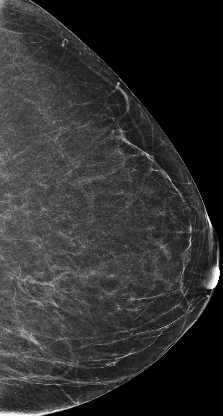

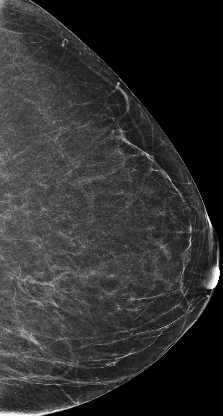


----------------



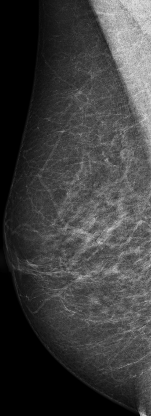

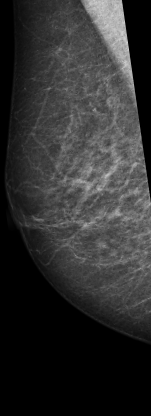


----------------



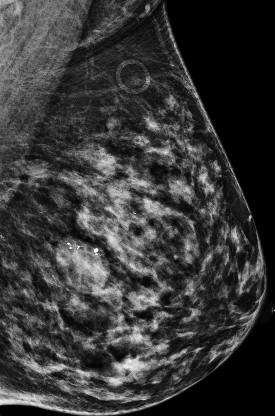

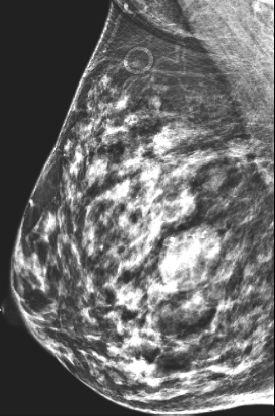


----------------



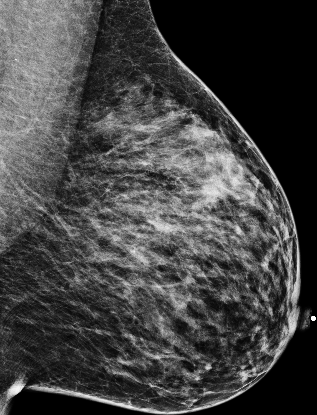

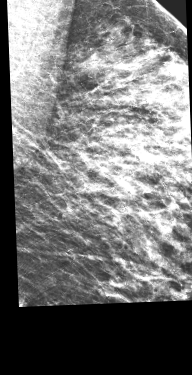


----------------



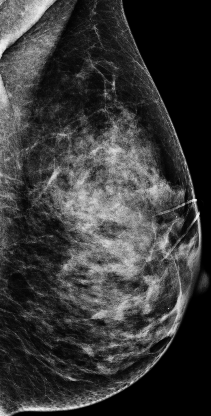

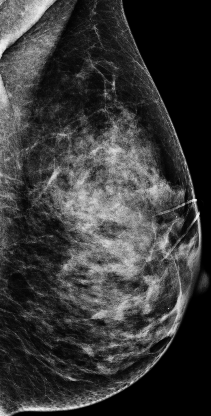


----------------



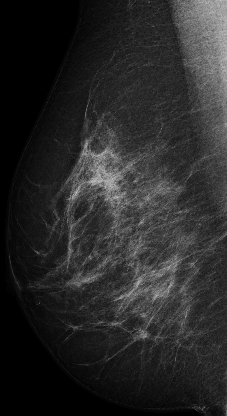

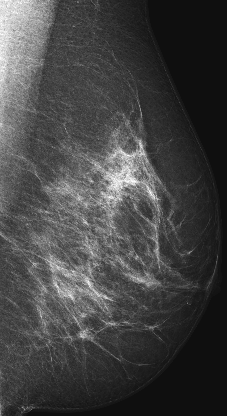


----------------



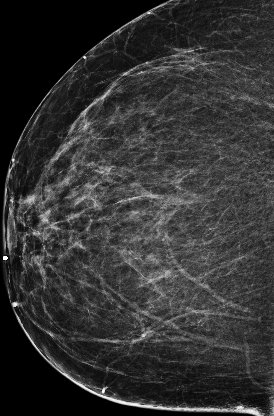

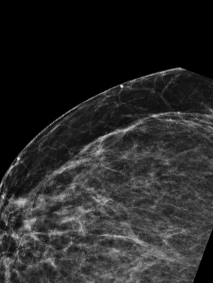


----------------



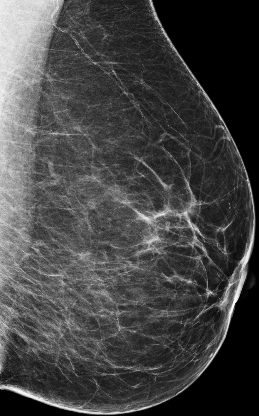

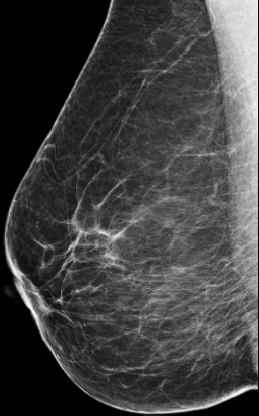


----------------



ValueError: Unsupported image type float32

In [14]:
transforms = [

    A.Compose(
            [
                # crop
                CustomRandomSizedCropNoResize(scale=(0.5, 1.0),
                                                   ratio=(0.5, 0.8),
                                                   always_apply=False,
                                                   p=0.4),

                # flip
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),

                # downscale
                A.OneOf([
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LINEAR,
                                                   downscale=cv2.INTER_AREA),
                                always_apply=False,
                                p=0.1),
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LANCZOS4,
                                                   downscale=cv2.INTER_AREA),
                                always_apply=False,
                                p=0.1),
                    A.Downscale(scale_min=0.75,
                                scale_max=0.95,
                                interpolation=dict(upscale=cv2.INTER_LINEAR,
                                                   downscale=cv2.INTER_LINEAR),
                                always_apply=False,
                                p=0.8),
                ],
                        p=0.125),

                # contrast
                # relative dark/bright between region, like HDR
                A.OneOf([
                    # uint8 only
                    A.RandomToneCurve(scale=0.3, always_apply=False, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                                               contrast_limit=(-0.4, 0.5),
                                               brightness_by_max=True,
                                               always_apply=False,
                                               p=0.5)
                ],
                        p=0.5),

                # affine
                A.OneOf(
                    [
                        A.ShiftScaleRotate(shift_limit=None,
                                           scale_limit=[-0.15, 0.15],
                                           rotate_limit=[-30, 30],
                                           interpolation=cv2.INTER_LINEAR,
                                           border_mode=cv2.BORDER_CONSTANT,
                                           value=0,
                                           mask_value=None,
                                           shift_limit_x=[-0.1, 0.1],
                                           shift_limit_y=[-0.2, 0.2],
                                           rotate_method='largest_box',
                                           always_apply=False,
                                           p=0.6),

                        # one of with other affine
                        A.ElasticTransform(alpha=1,
                                           sigma=20,
                                           alpha_affine=10,
                                           interpolation=cv2.INTER_LINEAR,
                                           border_mode=cv2.BORDER_CONSTANT,
                                           value=0,
                                           mask_value=None,
                                           approximate=False,
                                           same_dxdy=False,
                                           always_apply=False,
                                           p=0.2),

                        # distort
                        A.GridDistortion(num_steps=5,
                                         distort_limit=0.3,
                                         interpolation=cv2.INTER_LINEAR,
                                         border_mode=cv2.BORDER_CONSTANT,
                                         value=0,
                                         mask_value=None,
                                         normalized=True,
                                         always_apply=False,
                                         p=0.2),
                    ],
                    p=0.5),

                # random erase
                A.CoarseDropout(max_holes=6,
                                max_height=0.15,
                                max_width=0.25,
                                min_holes=1,
                                min_height=0.05,
                                min_width=0.1,
                                fill_value=0,
                                mask_fill_value=None,
                                always_apply=False,
                                p=0.25),
            ],
            p=0.9)
]
viz([img.astype(np.float32) for img in imgs], transforms)



In [ ]:
transforms = [
    breast_transforms
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.HorizontalFlip(p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ShiftScaleRotate(shift_limit=None, scale_limit=[-0.15, 0.15], rotate_limit=[-30, 30],
                        interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT,
                        value=0, mask_value=None,
                        shift_limit_x=[-0.1, 0.1], shift_limit_y=[-0.2, 0.2],
                        rotate_method='largest_box',
                        always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    CustomRandomSizedCropNoResize(scale=(0.5, 1.0), ratio=(0.5, 0.8),
                                    always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
R = 0.2

transforms = [
    A.CoarseDropout(max_holes=6, max_height=0.15, max_width=0.25, min_holes=2,
                    min_height=0.05, min_width=0.1, fill_value=0, mask_fill_value=None,
                    always_apply = True, p=1.0)
]
viz(imgs, transforms)



In [ ]:
transforms = [
    A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, interpolation=cv2.INTER_LINEAR,
                      border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None,
                      approximate=False, same_dxdy=False,
                        always_apply=True, p=1.0)

]
viz(imgs, transforms)



In [ ]:
transforms = [
    A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_LINEAR,
                   border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, normalized=True,
                   always_apply=False, p=1.0)
]
viz(imgs, transforms)



In [ ]:
transforms = [
    A.RandomToneCurve(scale=0.3, always_apply=True, p=1.0)
]
viz(imgs, transforms)



In [ ]:
transforms = [
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2), contrast_limit=(-0.4, 0.5),
                               brightness_by_max=True,
                               always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.AdvancedBlur(blur_limit=(3, 7),
                  sigmaX_limit=(0.2, 1.0),
                  sigmaY_limit=(0.2, 1.0),
                  rotate_limit=90,
                  beta_limit=(0.5, 8.0),
                  noise_limit=(0.9, 1.1),
                  always_apply=True,
                  p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ChannelDropout(channel_drop_range=(1, 1), fill_value=128, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ChannelShuffle(p= 1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ColorJitter(brightness=[0.6, 1.2],
                  contrast=[0.8, 1.3],
                  saturation=[0.7, 1.3],
                  hue=[-0.05, 0.05],
                  always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ColorJitter(brightness=[1.0, 1.0],
                  contrast=[1.0, 1.0],
                  saturation=[1.0, 1.0],
                  hue=[0.1, 0.1],
                  always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
from albumentations.augmentations.blur.transforms import Defocus

In [ ]:
transforms = [
    A.Defocus(radius=(3, 3),
              alias_blur=(0.1, 0.1),
              always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Downscale(scale_min=0.6, scale_max=0.9, interpolation=cv2.INTER_CUBIC, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Emboss(alpha=(1.0, 1.0), strength=(1.0, 1.0), always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
type(imgs)

In [ ]:
dir_name = '/home/dangnh/Projects/face_liveness/data/train/frames/1667/'
fake_names = os.listdir(dir_name)
fake_paths = [os.path.join(dir_name, name) for name in fake_names]

# dir_name = '/home/dangnh/Projects/face_liveness/data/train/frames/1654/'
# fake_names = os.listdir(dir_name)
# fake_paths = [os.path.join(dir_name, name) for name in fake_names]

In [ ]:
transforms = [
    A.FDA(fake_paths, beta_limit=[0.9, 0.95], always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.FancyPCA(alpha=0.9, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.GaussNoise(var_limit=(10.0, 20.0), mean=0, per_channel=True, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.GlassBlur(sigma=0.7, max_delta=1, iterations=2, always_apply=True, mode='fast', p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ISONoise(color_shift=(0.00, 0.00), intensity=(0.5, 0.5), always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
A.transforms.ImageCompression.ImageCompressionType.JPEG

In [ ]:
transforms = [
    A.ImageCompression(quality_lower=60, quality_upper= 90,
                       compression_type=A.transforms.ImageCompression.ImageCompressionType.JPEG,
                       always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ImageCompression(quality_lower=60, quality_upper= 60,
                       compression_type=A.transforms.ImageCompression.ImageCompressionType.WEBP,
                       always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.MedianBlur(blur_limit=(3,3), always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.MotionBlur(blur_limit=(3,5), allow_shifted=True, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Posterize(num_bits=4, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RGBShift(r_shift_limit=[-20, 20], g_shift_limit=[-20, 20], b_shift_limit=[-20, 20], always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomToneCurve(scale=0.2, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomGamma(gamma_limit=(120, 120), eps=None, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Spatter (mean=0.65, std=0.3, gauss_sigma=2, cutout_threshold=0.68,
               intensity=0.6, mode='mud', color=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Solarize(threshold=128, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RingingOvershoot(blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966),
                       always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ToGray(p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ZoomBlur(max_factor=[1.1, 1.1], step_factor=(0.01, 0.01), always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ToSepia(always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.BBoxSafeRandomCrop(erosion_rate=0.0, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.CenterCrop(100, 100, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.CoarseDropout(max_holes=3, max_height=0.2, max_width=0.2, min_holes=3,
       min_height=0.1, min_width=0.1, fill_value=0,
       mask_fill_value=None, always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ElasticTransform (alpha=1, sigma=50, alpha_affine=50, interpolation=1,
                        border_mode=4, value=None, mask_value=None, always_apply=False,
                        approximate=False, same_dxdy=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1,
                     border_mode=4, value=None, mask_value=None, normalized=False,
                     always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.GridDropout(ratio=0.5, unit_size_min=None, unit_size_max=None, holes_number_x=None, holes_number_y=None, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.HorizontalFlip(p = 1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Lambda(image=None, mask=None, keypoint=None, bbox=None, name=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.PadIfNeeded (min_height=1024, min_width=1024, pad_height_divisor=None, pad_width_divisor=None,
                   position=A.augmentations.geometric.transforms.PadIfNeeded.PositionType.CENTER,
                   border_mode=0, value=None,
                   mask_value=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
cv2.BORDER_CONSTANT

In [ ]:
transforms = [
    A.Perspective(scale=(0.1, 0.1), keep_size=True, pad_mode=0, pad_val=0,
                  mask_pad_val=0, fit_output=False, interpolation=1,
                  always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.PixelDropout(dropout_prob=0.2, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomCropFromBorders(crop_left=0.3, crop_right=0.3, crop_top=0.1, crop_bottom=0.1,
                            always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomGridShuffle (grid=(3, 3), always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomResizedCrop (384, 384, scale=(0.9, 0.9), ratio=(0.75, 1.3333333333333333),
                         interpolation=1, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Rotate (limit=[-15, 15], interpolation=1, border_mode=0, value=0, mask_value=None,
              rotate_method='largest_box', crop_border=False,
              always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.SafeRotate(limit=[30, 30], interpolation=1, border_mode=0, value=9, mask_value=None, always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.ShiftScaleRotate (shift_limit=[-0.2, -0.2], scale_limit=[0, 0], rotate_limit=[0, 0],
                        interpolation=1, border_mode=0, value=0, mask_value=None,
                        shift_limit_x=None, shift_limit_y=None, rotate_method='largest_box',
                        always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Transpose(p = 1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.CustomRandomSizedCropNoResize(scale=(0.99, 0.99), ratio=(1., 1.),
                                    always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.Defocus(radius=(3, 3),
              alias_blur=(0.9, 0.9),
              always_apply=True, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.RandomCropFromBorders(crop_left=0.2, crop_right=0.2, crop_top=0.2, crop_bottom=0.2,
                            always_apply=False, p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.AdvancedBlur(blur_limit=(5, 5),
              sigmaX_limit=(0.2, 1.0),
              sigmaY_limit=(0.2, 1.0),
              rotate_limit=90,
              beta_limit=(0.5, 8.0),
              noise_limit=(0.9, 1.1),
              always_apply=False,
              p=1.0)
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.
]
viz(imgs, transforms)

In [ ]:
transforms = [
    A.
]
viz(imgs, transforms)